In [1]:
import numpy as np
import pandas as pd
from scipy import stats
from dateutil import parser
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import statistics
from collections import defaultdict
import json
import datetime
import time
import datetime as dt

DATA_PATH = '../processed_data/'

all_data = pd.read_csv(DATA_PATH + 'allDataCombined.csv')
price_data = pd.read_csv(DATA_PATH + 'priceData.csv')
df = pd.merge(all_data, price_data, on="timestamp")
df['date'] = df['timestamp'].apply(lambda x: parser.parse(x).date())
df['time'] = df['timestamp'].apply(lambda x: parser.parse(x).strftime("%H:%M:%S"))
corr = []
corr_all = []
pnl = defaultdict(list)
index = 0

df['NOPE'] = df['NOPE_busVolume'] * 100

# remove feb 19 2020 through march 23 2020 for testing short strategies

In [2]:
#for short testing, remove feb 19 2020 to march 23 2020
temp1 = df[df['date'] < datetime.date(2020, 2, 19)] 
temp2 = df[df['date'] > datetime.date(2020, 3, 23)] 

In [3]:
dfshort = pd.concat([temp1, temp2], axis=0)

In [4]:
dfshort = dfshort.reset_index(drop=True)

In [5]:
#add time column in datetime
dfshort['timeDT'] = pd.to_datetime(dfshort['time'])

In [6]:
entry_time = []
exit_time = []
winloss = []

def backtest_short(day_group, short_entry, short_exit, timelimit):
    values = []
    trade_in_progress = False
    entry_price = None
    exit_price = None
    total_pnl = 0
    for index, row in day_group.iterrows():
        if row['NOPE_busVolume']*100 >= short_entry and not trade_in_progress and row['time'] > '09:45:00' and row['time'] < '14:45:00':
            entry_price = (row['NOPE_busVolume']*100, row['time'], row['active_underlying_price'])
            entry_time.append(row['timeDT'])
            trade_in_progress = True
        if trade_in_progress:
            if row['NOPE_busVolume']*100 <= short_exit or (row['timeDT'] - entry_time[-1]) > dt.timedelta(minutes = timelimit):
                exit_price = (row['NOPE_busVolume']*100,row['time'],row['active_underlying_price'])
                values.append((entry_price, exit_price))
                total_pnl = total_pnl + (entry_price[2] - exit_price[2])
                if (entry_price[2] - exit_price[2]) < 0:
                        winloss.append(False)
                else:
                    winloss.append(True)
                trade_in_progress = False
                entry_price = None
                exit_price = None
                exit_time.append(row['timeDT'])
        if row['time'] == '16:00:00':
            if trade_in_progress:
                exit_price = (row['NOPE_busVolume']*100,row['time'],row['active_underlying_price'])
                values.append((entry_price, exit_price))
                total_pnl = total_pnl + (entry_price[2] - exit_price[2])
                exit_time.append(row['timeDT'])
                if (entry_price[2] - exit_price[2]) < 0:
                    winloss.append(False)
                else:
                    winloss.append(True)
                trade_in_progress = False
                entry_price = None
                exit_price = None
            break
    return (values, total_pnl)

In [8]:
pnl_list = []
t0 = time.time()

total_pnl = defaultdict(tuple)
real_total_pnl = 0
for name, group in dfshort.groupby('date'):
    total_pnl[str(name)] = backtest_short(group, 30, 15, 2000)
    real_total_pnl = real_total_pnl + total_pnl[str(name)][1]
pnl_list.append(real_total_pnl)


t1 = time.time()
t1 - t0

1.1721532344818115

# Testing hold times

In [9]:
holdtimes = pd.DataFrame()
holdtimes['entry'] = entry_time
holdtimes['exit'] = exit_time
holdtimes['winloss'] = winloss
holdtimes['delta'] = holdtimes['exit'] - holdtimes['entry']
holdtimes['minutes'] = holdtimes['delta'].dt.total_seconds()/60

Text(0, 0.5, 'Counts')

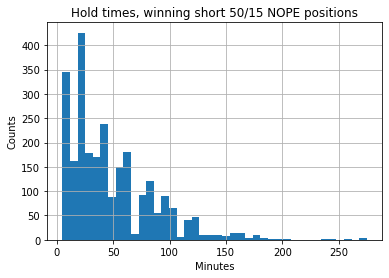

In [10]:
holdtimes[holdtimes['winloss'] == True]['minutes'].hist(bins=40)

plt.title("Hold times, winning short 50/15 NOPE positions")
plt.xlabel("Minutes")
plt.ylabel("Counts")

Text(0, 0.5, 'Counts')

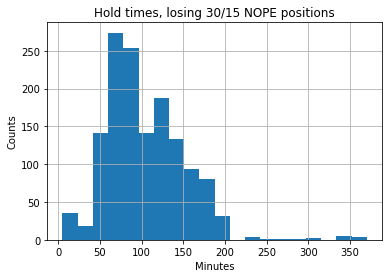

In [11]:
holdtimes[holdtimes['winloss'] == False]['minutes'].hist(bins=20)
plt.title("Hold times, losing 30/15 NOPE positions")
plt.xlabel("Minutes")
plt.ylabel("Counts")

In [12]:
sum(holdtimes['entry'].dt.time > datetime.time(14, 30))

104

In [13]:
len(holdtimes['entry'])

3971

(array([503., 103., 250.,  47., 116.,  61.,  95.,  63.,  80.,  92., 100.,
        109.,  85., 103., 181., 124.,  73., 176., 106.,  95.]),
 array([590. , 604.5, 619. , 633.5, 648. , 662.5, 677. , 691.5, 706. ,
        720.5, 735. , 749.5, 764. , 778.5, 793. , 807.5, 822. , 836.5,
        851. , 865.5, 880. ]),
 <BarContainer object of 20 artists>)

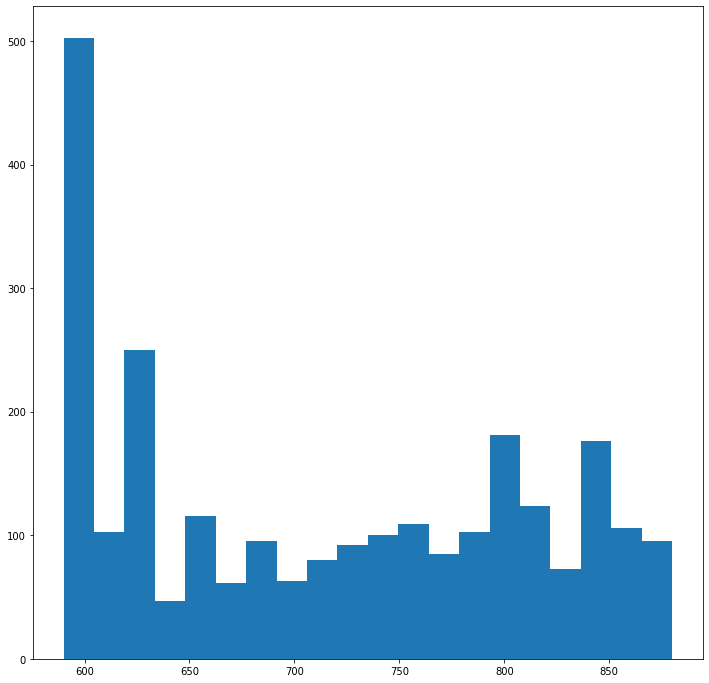

In [14]:
ToD = (holdtimes[holdtimes['winloss'] == True]['entry'].dt.hour*60) + (holdtimes[holdtimes['winloss'] == True]['entry'].dt.minute)
plt.figure(figsize=(12,12))
plt.hist(ToD, bins=20)

(array([217., 105., 102.,  17.,  83.,  44.,  43.,  53.,  56.,  28.,  17.,
         63.,  75.,  52.,  72.,  65.,  58.,  91., 122.,  46.]),
 array([590. , 604.5, 619. , 633.5, 648. , 662.5, 677. , 691.5, 706. ,
        720.5, 735. , 749.5, 764. , 778.5, 793. , 807.5, 822. , 836.5,
        851. , 865.5, 880. ]),
 <BarContainer object of 20 artists>)

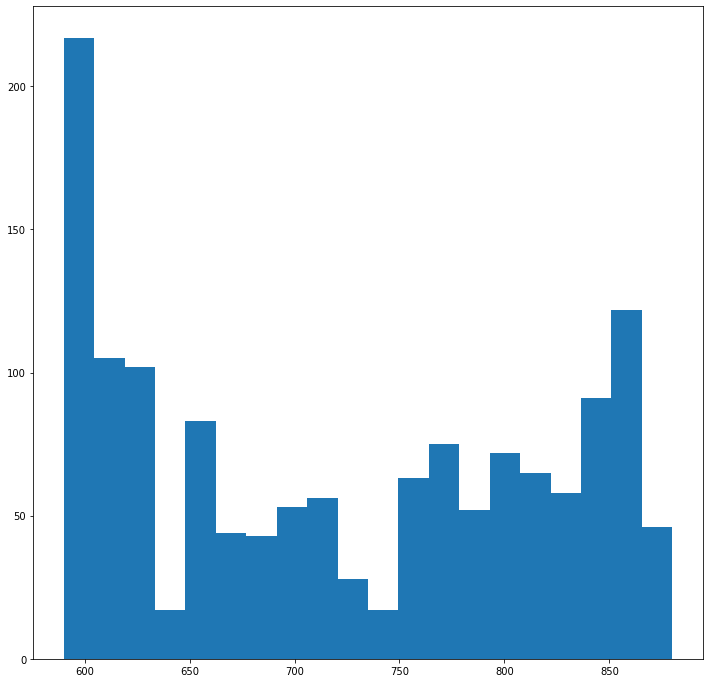

In [15]:
ToD = (holdtimes[holdtimes['winloss'] == False]['entry'].dt.hour*60) + (holdtimes[holdtimes['winloss'] == False]['entry'].dt.minute)
plt.figure(figsize=(12,12))
plt.hist(ToD, bins=20)

<AxesSubplot:>

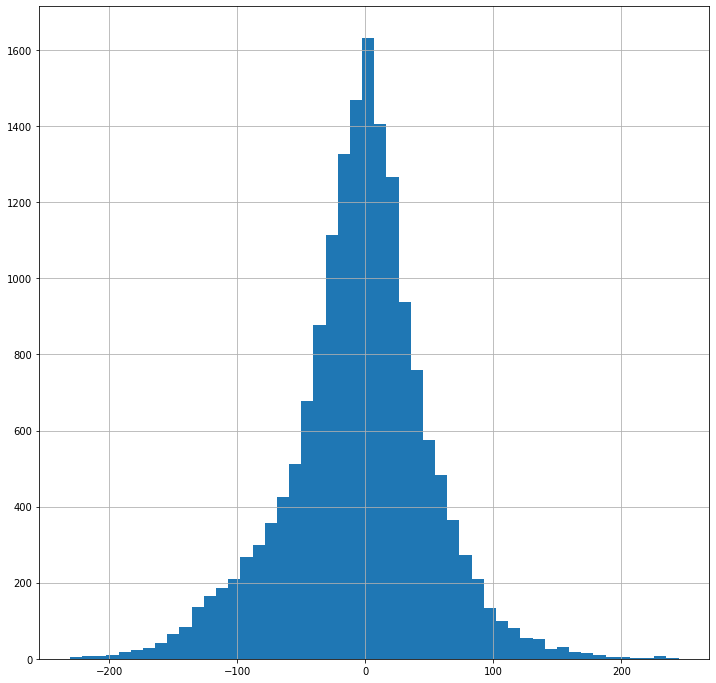

In [16]:
plt.figure(figsize=(12,12))
dfshort['NOPE'].hist(bins=50)

# Investigate reversion time vs NOPE entry

In [17]:
days = []
for name, group in dfshort.groupby('date'):
    days.append(group)

for i in range(0, len(days)):
    days[i] = days[i].reset_index(drop=True)

In [18]:
reversiontimes = pd.DataFrame()
reversiontimes['start'] = np.zeros([4000])
reversiontimes['time'] = np.zeros([4000])

In [47]:
k = 0


for j in range(0, len(days)):
    for i, elem in days[j].iterrows():
        if elem['NOPE'] > 30:
            #record starting NOPE score
            reversiontimes['start'][k] = elem['NOPE']
            #find time to NOPE score < 15 in minutes
            reversiontimes['time'][k] = (days[j]['NOPE'][i:].lt(15).idxmax() - i) * 5
            k = k + 1

        
        
reversiontimes = reversiontimes[reversiontimes['time'] != 0]
revert = reversiontimes.reset_index(drop=True)

In [66]:
days[0]['NOPE'].lt(-50).sum()

0

In [43]:
revert = revert[revert['start'] < 100]

Text(0, 0.5, 'Time to NOPE 15')

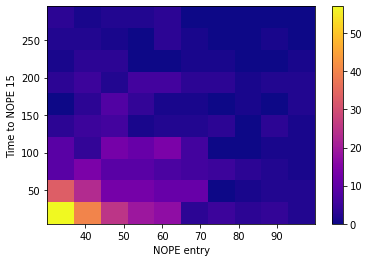

In [44]:
fig, ax = plt.subplots()

h = ax.hist2d(revert['start'], revert['time'], cmap='plasma')

fig.colorbar(h[3], ax=ax)
plt.xlabel('NOPE entry')
plt.ylabel('Time to NOPE 15')

In [45]:
revert.sort_values('start')

start   time
581  30.017585   15.0
37   30.040021   15.0
167  30.061909   60.0
576  30.150220   45.0
477  30.181294   50.0
..         ...    ...
158  97.166017  180.0
32   98.767606   95.0
222  99.338988  190.0
284  99.522596   60.0
209  99.912486   25.0

[518 rows x 2 columns]

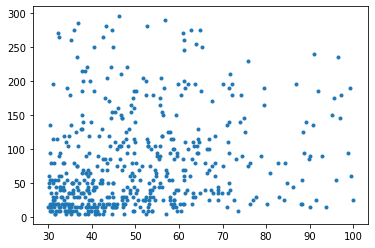

In [46]:
plt.plot(revert['start'], revert['time'], '.')